In [19]:
import torch
import clip
import time
import shutil
import math
import random

import numpy as np
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets

import torch.nn as nn
import torch.optim as optim
import torch.utils.data


torch.cuda.is_available()


start_epoch = 0
epochs = 200
batch_size = 32
lr = 30
print_frequency = 10


class MLP(nn.Module):
    def __init__(self, dim):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(dim, 128)
        self.BN1 = nn.BatchNorm1d(128)
        self.out = nn.Linear(128, 2)
        self.BN2 = nn.BatchNorm1d(2)
        
    def forward(self, x):
        x = x.to(torch.float32)
        x = self.BN1(self.hidden1(x))
        x = F.relu(x)
        x = self.BN2(self.out(x))
        return x

class myMoCo(nn.Module):
    def __init__(self):
        super(myMoCo, self).__init__()
        
        self.pos = 4 #the number of positive samples
        
        self.indim = 512
        self.outdim = 2
        self.m = 0.999
        self.T = 0.07
        self.K = 256
        
        self.mlp_q = MLP(self.indim).cuda()
        self.mlp_k = MLP(self.indim).cuda()
        for param_q, param_k in zip(self.mlp_q.parameters(), self.mlp_k.parameters()):
            param_k.data.copy_(param_q.data) #initialize key MLP
            param_k.required_grad = False
        
        self.register_buffer("queue", torch.randn(self.K, self.outdim))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))   
        
    """
    input_q : Batch x feat_size == N x inDim
    input_k : (Batch x pos_pairs) x feat_size == (N x J) x inDim ==> M x inDim
    """ 
    def forward(self, pos_pairs):
        input_q = pos_pairs[:,:1,:] #N x 1  x inDim
        input_q = input_q.squeeze() #N x inDim
        input_q = nn.functional.normalize(input_q, dim=1)
        
        q = self.mlp_q(input_q) # N x outDim
        q = nn.functional.normalize(q, dim=1)
        
        with torch.no_grad():
            input_k = pos_pairs[:,1:,:] #N x J x inDim
            N = input_k.shape[0]
            J = input_k.shape[1]
            input_k = torch.reshape(input_k, (-1, self.indim)) # reshape : (N x J) x inDim ==> M x inDim
            input_k = nn.functional.normalize(input_k, dim=1)
            
            k = self.mlp_k(input_k) # M x outDim
            k = nn.functional.normalize(k, dim=1)
            
            k = torch.reshape(k, (N, -1, self.outdim)) # undo reshape : M x outDim ==>(N x J) x outDim
        
        N = q.shape[0]
        loss_pos = torch.zeros([N,1]).cuda() # N x 1
        for i in range(N):
            sum_cos_pos = 0
            for j in range(self.pos-1):
                sum_cos_pos +=  F.cosine_similarity(q[i], k[i, j, :], dim=0)
            loss_pos[i] += sum_cos_pos/(self.pos-1)
        
        loss_neg = torch.zeros([1,self.K]).cuda() # 1 x K
        for j in range(N):
            cos = F.cosine_similarity(q[j].unsqueeze(0), self.queue.clone().detach(), dim=1).unsqueeze(0) # 1 x K
            loss_neg = torch.cat([loss_neg, cos], dim=0)
        loss_neg = loss_neg[1:] # N x K
        
        
        logits = torch.cat([loss_pos, loss_neg], dim=1) # N x (1+K)
        logits /= self.T
        
        labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()
        
        self._dequeue_and_enqueue(k)
        
        return logits, labels
    
    
    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.mlp_q.parameters(), self.mlp_k.parameters()):
            param_k.data = param_k.data*self.m + param_q.data*(1.0-self.m)
        
    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        chosen = random.randint(0, self.pos-2)
        k = keys[:, chosen, :].squeeze() #chose one view: N x J x C ==> N x 1 x C ==> N x C
        M = k.shape[0]
        ptr = int(self.queue_ptr)
        self.queue[ptr : ptr + M, :] = k
        ptr = (ptr + M) % self.K
        self.queue_ptr[0] = ptr

def adjust_learning_rate(optimizer, epoch):
    lr = 1e-3
    lr *= 0.5 * (1.0 + math.cos(math.pi * epoch / epochs))
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def save_checkpoint(state, is_best, filename):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, "model_best.pth.tar")


def train(train_loader, model, criterion, optimizer, epoch):
    for i, pos_pairs in enumerate(train_loader):
        
        output, target = model(pos_pairs)
        loss = criterion(output, target)
       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('Epoch[{0}]    Iter[{1}/8]    Loss: {2}'.format(epoch+1, i+1, loss))
        

def main():
    
    model = myMoCo().cuda()
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = optim.SGD(
        model.parameters(), 
        lr = 1e-3,
        momentum = 0.9,
        weight_decay = 1e-4
    )
    
    """
    # optionally resume from a checkpoint
    ...
    """
    
    cudnn.benchmark = True
    
    train_file = '../CUHK01/dataset.pkl'
    N = 256
    B = 32
    
    train_dataset = torch.load(train_file).cuda()
    train_dataset = train_dataset[:N]
    
    trainloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = B,
        shuffle = True
    )
    
    for epoch in range(start_epoch, epochs):
        
        adjust_learning_rate(optimizer, epoch)
        train(trainloader, model, criterion, optimizer, epoch)
        
        print('\n\n')
        
        torch.save(model.mlp_q.state_dict(), './pretrained/MLP/mlp{:04d}.pth.tar'.format(epoch+1))
        save_checkpoint(
            {
                "epoch": epoch + 1,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            },
            is_best=False,
            filename="./pretrained/myMoCo/checkpoint_{:04d}.pth.tar".format(epoch+1),
        )


main()
print('DONE!')

Epoch[1]    Iter[1/8]    Loss: 14.500236511230469
Epoch[1]    Iter[2/8]    Loss: 14.68173599243164
Epoch[1]    Iter[3/8]    Loss: 14.09798812866211
Epoch[1]    Iter[4/8]    Loss: 12.395803451538086
Epoch[1]    Iter[5/8]    Loss: 13.589404106140137
Epoch[1]    Iter[6/8]    Loss: 15.813739776611328
Epoch[1]    Iter[7/8]    Loss: 14.175565719604492
Epoch[1]    Iter[8/8]    Loss: 16.013206481933594



Epoch[2]    Iter[1/8]    Loss: 13.342803955078125
Epoch[2]    Iter[2/8]    Loss: 14.077282905578613
Epoch[2]    Iter[3/8]    Loss: 13.434141159057617
Epoch[2]    Iter[4/8]    Loss: 14.948890686035156
Epoch[2]    Iter[5/8]    Loss: 14.54172134399414
Epoch[2]    Iter[6/8]    Loss: 15.141180038452148
Epoch[2]    Iter[7/8]    Loss: 13.823591232299805
Epoch[2]    Iter[8/8]    Loss: 14.385422706604004



Epoch[3]    Iter[1/8]    Loss: 14.844563484191895
Epoch[3]    Iter[2/8]    Loss: 13.124165534973145
Epoch[3]    Iter[3/8]    Loss: 13.639741897583008
Epoch[3]    Iter[4/8]    Loss: 13.6172237396240

Epoch[22]    Iter[1/8]    Loss: 10.922859191894531
Epoch[22]    Iter[2/8]    Loss: 10.6262788772583
Epoch[22]    Iter[3/8]    Loss: 11.168655395507812
Epoch[22]    Iter[4/8]    Loss: 12.659213066101074
Epoch[22]    Iter[5/8]    Loss: 10.082025527954102
Epoch[22]    Iter[6/8]    Loss: 9.160595893859863
Epoch[22]    Iter[7/8]    Loss: 9.207291603088379
Epoch[22]    Iter[8/8]    Loss: 10.987919807434082



Epoch[23]    Iter[1/8]    Loss: 9.438861846923828
Epoch[23]    Iter[2/8]    Loss: 10.3034086227417
Epoch[23]    Iter[3/8]    Loss: 11.279923439025879
Epoch[23]    Iter[4/8]    Loss: 11.197929382324219
Epoch[23]    Iter[5/8]    Loss: 10.259679794311523
Epoch[23]    Iter[6/8]    Loss: 10.964624404907227
Epoch[23]    Iter[7/8]    Loss: 10.848857879638672
Epoch[23]    Iter[8/8]    Loss: 9.59996509552002



Epoch[24]    Iter[1/8]    Loss: 10.930797576904297
Epoch[24]    Iter[2/8]    Loss: 9.529264450073242
Epoch[24]    Iter[3/8]    Loss: 9.73452377319336
Epoch[24]    Iter[4/8]    Loss: 9.789

Epoch[42]    Iter[6/8]    Loss: 10.147035598754883
Epoch[42]    Iter[7/8]    Loss: 10.29943561553955
Epoch[42]    Iter[8/8]    Loss: 9.19856071472168



Epoch[43]    Iter[1/8]    Loss: 9.890644073486328
Epoch[43]    Iter[2/8]    Loss: 9.876166343688965
Epoch[43]    Iter[3/8]    Loss: 9.372597694396973
Epoch[43]    Iter[4/8]    Loss: 9.648802757263184
Epoch[43]    Iter[5/8]    Loss: 9.987923622131348
Epoch[43]    Iter[6/8]    Loss: 8.967706680297852
Epoch[43]    Iter[7/8]    Loss: 9.409111022949219
Epoch[43]    Iter[8/8]    Loss: 11.31644058227539



Epoch[44]    Iter[1/8]    Loss: 9.358781814575195
Epoch[44]    Iter[2/8]    Loss: 10.040000915527344
Epoch[44]    Iter[3/8]    Loss: 9.697646141052246
Epoch[44]    Iter[4/8]    Loss: 10.110052108764648
Epoch[44]    Iter[5/8]    Loss: 9.988398551940918
Epoch[44]    Iter[6/8]    Loss: 10.069818496704102
Epoch[44]    Iter[7/8]    Loss: 9.13556957244873
Epoch[44]    Iter[8/8]    Loss: 10.334930419921875



Epoch[45]    Iter[1/8]    Loss: 10.138

Epoch[63]    Iter[6/8]    Loss: 9.444429397583008
Epoch[63]    Iter[7/8]    Loss: 10.012370109558105
Epoch[63]    Iter[8/8]    Loss: 9.193022727966309



Epoch[64]    Iter[1/8]    Loss: 10.818666458129883
Epoch[64]    Iter[2/8]    Loss: 10.930093765258789
Epoch[64]    Iter[3/8]    Loss: 10.06937026977539
Epoch[64]    Iter[4/8]    Loss: 10.416221618652344
Epoch[64]    Iter[5/8]    Loss: 8.701812744140625
Epoch[64]    Iter[6/8]    Loss: 9.891034126281738
Epoch[64]    Iter[7/8]    Loss: 9.50554370880127
Epoch[64]    Iter[8/8]    Loss: 9.283223152160645



Epoch[65]    Iter[1/8]    Loss: 9.18776798248291
Epoch[65]    Iter[2/8]    Loss: 10.062256813049316
Epoch[65]    Iter[3/8]    Loss: 10.021695137023926
Epoch[65]    Iter[4/8]    Loss: 10.597921371459961
Epoch[65]    Iter[5/8]    Loss: 9.621010780334473
Epoch[65]    Iter[6/8]    Loss: 9.524539947509766
Epoch[65]    Iter[7/8]    Loss: 9.210587501525879
Epoch[65]    Iter[8/8]    Loss: 10.36937427520752



Epoch[66]    Iter[1/8]    Loss: 10.0

Epoch[84]    Iter[2/8]    Loss: 9.758185386657715
Epoch[84]    Iter[3/8]    Loss: 10.063790321350098
Epoch[84]    Iter[4/8]    Loss: 9.251322746276855
Epoch[84]    Iter[5/8]    Loss: 10.061882019042969
Epoch[84]    Iter[6/8]    Loss: 10.453892707824707
Epoch[84]    Iter[7/8]    Loss: 8.887958526611328
Epoch[84]    Iter[8/8]    Loss: 9.483865737915039



Epoch[85]    Iter[1/8]    Loss: 9.51668930053711
Epoch[85]    Iter[2/8]    Loss: 10.076138496398926
Epoch[85]    Iter[3/8]    Loss: 9.941286087036133
Epoch[85]    Iter[4/8]    Loss: 9.72559642791748
Epoch[85]    Iter[5/8]    Loss: 10.3002347946167
Epoch[85]    Iter[6/8]    Loss: 9.487104415893555
Epoch[85]    Iter[7/8]    Loss: 10.010503768920898
Epoch[85]    Iter[8/8]    Loss: 10.019475936889648



Epoch[86]    Iter[1/8]    Loss: 9.644227027893066
Epoch[86]    Iter[2/8]    Loss: 8.970258712768555
Epoch[86]    Iter[3/8]    Loss: 9.86291217803955
Epoch[86]    Iter[4/8]    Loss: 10.505855560302734
Epoch[86]    Iter[5/8]    Loss: 10.486141

Epoch[104]    Iter[4/8]    Loss: 10.161664962768555
Epoch[104]    Iter[5/8]    Loss: 9.600589752197266
Epoch[104]    Iter[6/8]    Loss: 9.566984176635742
Epoch[104]    Iter[7/8]    Loss: 8.27343463897705
Epoch[104]    Iter[8/8]    Loss: 10.392231941223145



Epoch[105]    Iter[1/8]    Loss: 11.032526016235352
Epoch[105]    Iter[2/8]    Loss: 8.907485008239746
Epoch[105]    Iter[3/8]    Loss: 9.675554275512695
Epoch[105]    Iter[4/8]    Loss: 10.213410377502441
Epoch[105]    Iter[5/8]    Loss: 9.28142261505127
Epoch[105]    Iter[6/8]    Loss: 11.001350402832031
Epoch[105]    Iter[7/8]    Loss: 9.767105102539062
Epoch[105]    Iter[8/8]    Loss: 9.091108322143555



Epoch[106]    Iter[1/8]    Loss: 9.743471145629883
Epoch[106]    Iter[2/8]    Loss: 10.041112899780273
Epoch[106]    Iter[3/8]    Loss: 8.543874740600586
Epoch[106]    Iter[4/8]    Loss: 10.269989967346191
Epoch[106]    Iter[5/8]    Loss: 9.694713592529297
Epoch[106]    Iter[6/8]    Loss: 9.773963928222656
Epoch[106]    Iter[7

Epoch[124]    Iter[8/8]    Loss: 10.027902603149414



Epoch[125]    Iter[1/8]    Loss: 9.247522354125977
Epoch[125]    Iter[2/8]    Loss: 9.34957504272461
Epoch[125]    Iter[3/8]    Loss: 9.794093132019043
Epoch[125]    Iter[4/8]    Loss: 10.24958324432373
Epoch[125]    Iter[5/8]    Loss: 10.537758827209473
Epoch[125]    Iter[6/8]    Loss: 10.35592269897461
Epoch[125]    Iter[7/8]    Loss: 9.283880233764648
Epoch[125]    Iter[8/8]    Loss: 8.607949256896973



Epoch[126]    Iter[1/8]    Loss: 9.328557968139648
Epoch[126]    Iter[2/8]    Loss: 9.453271865844727
Epoch[126]    Iter[3/8]    Loss: 10.186771392822266
Epoch[126]    Iter[4/8]    Loss: 10.524480819702148
Epoch[126]    Iter[5/8]    Loss: 10.143662452697754
Epoch[126]    Iter[6/8]    Loss: 9.88196086883545
Epoch[126]    Iter[7/8]    Loss: 10.047930717468262
Epoch[126]    Iter[8/8]    Loss: 9.905624389648438



Epoch[127]    Iter[1/8]    Loss: 7.998312950134277
Epoch[127]    Iter[2/8]    Loss: 10.807162284851074
Epoch[127]    Ite

Epoch[145]    Iter[2/8]    Loss: 9.940051078796387
Epoch[145]    Iter[3/8]    Loss: 9.786681175231934
Epoch[145]    Iter[4/8]    Loss: 9.643607139587402
Epoch[145]    Iter[5/8]    Loss: 10.193557739257812
Epoch[145]    Iter[6/8]    Loss: 9.793277740478516
Epoch[145]    Iter[7/8]    Loss: 8.627150535583496
Epoch[145]    Iter[8/8]    Loss: 8.799280166625977



Epoch[146]    Iter[1/8]    Loss: 10.236051559448242
Epoch[146]    Iter[2/8]    Loss: 9.140581130981445
Epoch[146]    Iter[3/8]    Loss: 9.382316589355469
Epoch[146]    Iter[4/8]    Loss: 9.478330612182617
Epoch[146]    Iter[5/8]    Loss: 10.502544403076172
Epoch[146]    Iter[6/8]    Loss: 10.020584106445312
Epoch[146]    Iter[7/8]    Loss: 9.455175399780273
Epoch[146]    Iter[8/8]    Loss: 9.988964080810547



Epoch[147]    Iter[1/8]    Loss: 9.370494842529297
Epoch[147]    Iter[2/8]    Loss: 9.837139129638672
Epoch[147]    Iter[3/8]    Loss: 9.696484565734863
Epoch[147]    Iter[4/8]    Loss: 10.356281280517578
Epoch[147]    Iter[5

Epoch[165]    Iter[4/8]    Loss: 10.00955867767334
Epoch[165]    Iter[5/8]    Loss: 9.561114311218262
Epoch[165]    Iter[6/8]    Loss: 10.342816352844238
Epoch[165]    Iter[7/8]    Loss: 10.004449844360352
Epoch[165]    Iter[8/8]    Loss: 9.691905975341797



Epoch[166]    Iter[1/8]    Loss: 9.445466995239258
Epoch[166]    Iter[2/8]    Loss: 10.306856155395508
Epoch[166]    Iter[3/8]    Loss: 10.065218925476074
Epoch[166]    Iter[4/8]    Loss: 9.680362701416016
Epoch[166]    Iter[5/8]    Loss: 9.233826637268066
Epoch[166]    Iter[6/8]    Loss: 8.883194923400879
Epoch[166]    Iter[7/8]    Loss: 10.141705513000488
Epoch[166]    Iter[8/8]    Loss: 9.160674095153809



Epoch[167]    Iter[1/8]    Loss: 9.55035400390625
Epoch[167]    Iter[2/8]    Loss: 9.840798377990723
Epoch[167]    Iter[3/8]    Loss: 10.028100967407227
Epoch[167]    Iter[4/8]    Loss: 10.116449356079102
Epoch[167]    Iter[5/8]    Loss: 9.30142593383789
Epoch[167]    Iter[6/8]    Loss: 8.843931198120117
Epoch[167]    Iter[7

Epoch[185]    Iter[8/8]    Loss: 8.851883888244629



Epoch[186]    Iter[1/8]    Loss: 8.647210121154785
Epoch[186]    Iter[2/8]    Loss: 9.68454360961914
Epoch[186]    Iter[3/8]    Loss: 10.394227981567383
Epoch[186]    Iter[4/8]    Loss: 9.890490531921387
Epoch[186]    Iter[5/8]    Loss: 9.32276439666748
Epoch[186]    Iter[6/8]    Loss: 9.18864917755127
Epoch[186]    Iter[7/8]    Loss: 9.9238920211792
Epoch[186]    Iter[8/8]    Loss: 9.83858871459961



Epoch[187]    Iter[1/8]    Loss: 8.915184020996094
Epoch[187]    Iter[2/8]    Loss: 10.268674850463867
Epoch[187]    Iter[3/8]    Loss: 8.760906219482422
Epoch[187]    Iter[4/8]    Loss: 9.783111572265625
Epoch[187]    Iter[5/8]    Loss: 9.92901611328125
Epoch[187]    Iter[6/8]    Loss: 9.626773834228516
Epoch[187]    Iter[7/8]    Loss: 10.147339820861816
Epoch[187]    Iter[8/8]    Loss: 10.086196899414062



Epoch[188]    Iter[1/8]    Loss: 11.011738777160645
Epoch[188]    Iter[2/8]    Loss: 9.298905372619629
Epoch[188]    Iter[3/8] 

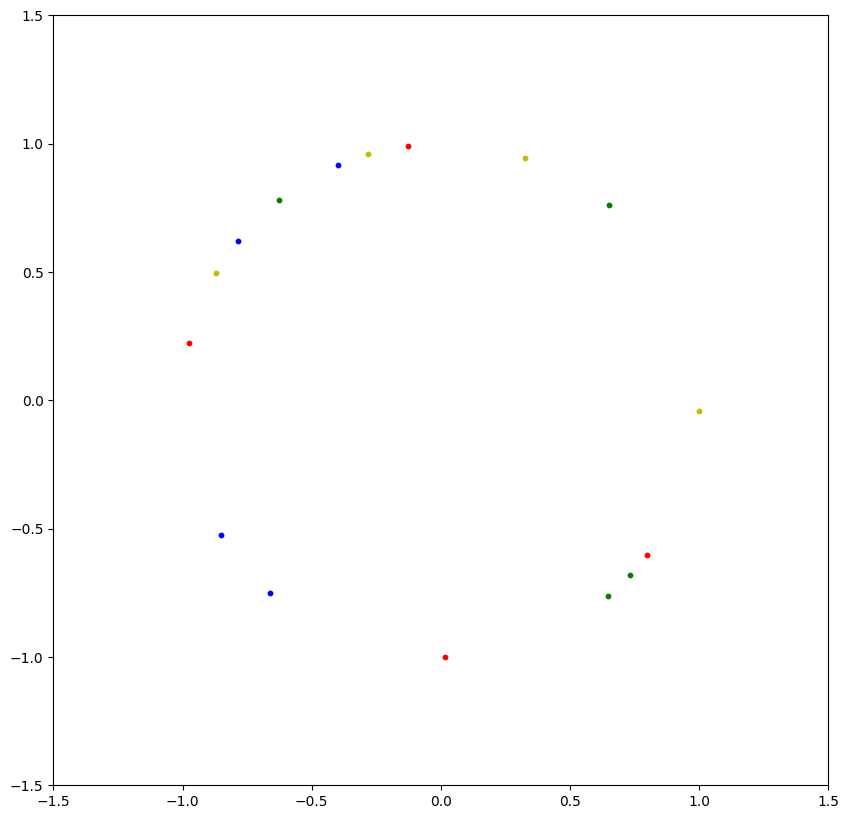

In [20]:
import matplotlib.pyplot as plt


def draw(x):

    color = ['r', 'y', 'g', 'b', 'm', 'c', 'k', 'w']
    ptr = 0
    
    fig = plt.figure(figsize=(10, 10))
    
    for pos in x:
        plt.scatter(pos.numpy()[:, 0], pos.numpy()[:, 1], c = color[ptr], s=10)
        ptr = (ptr+1)%len(color)
    
    plt.axis([-1.5, 1.5, -1.5, 1.5])
    plt.show()


weightdir = './pretrained/MLP/mlp0200.pth.tar'
weight = torch.load(weightdir)

mlp = MLP(512).cuda()
mlp.load_state_dict(weight)


path = '../CUHK01/dataset.pkl'
train_dataset = torch.load(path).cuda()

st = 300
end = 303
N = end-st+1
show_data = train_dataset[st:end+1]
inDim = show_data.shape[2]

inputs = show_data.reshape(-1, inDim)
outputs = mlp(inputs)
outputs = nn.functional.normalize(outputs, dim=1)
outputs = outputs.cpu().detach()

outDim = outputs.shape[1]
outputs = outputs.reshape(N, -1, outDim)


draw(outputs)